# ZNEUS PROJEKT 2 - CNN (Animals-10)

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## 1. EDA

First things first, we're going to pull up our data and label them, depending on the directory they are found in and place them inside a dataframe, so we can use them for later training.

The original names came in Italian, luckily the original poster of the dataset provided a python dictionary to translate the names. Bad news tho, the dictionary is incomplete (it lacks the spider column), so we had to modify it a little. We translate the names of the animals directly before labling and only keep the English labels.

In [3]:
# allow importing translate.py
sys.path.append('/kaggle/input/animals10')


root = "/kaggle/input/animals10/raw-img"

translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "Butterfly",
    "gallina": "hen",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel"
}

data = []

for folder_name in os.listdir(root):
    folder_path = os.path.join(root, folder_name)
    if not os.path.isdir(folder_path):
        continue

    eng_label = translate.get(folder_name, folder_name)

    for file in os.listdir(folder_path):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            data.append({
                "label": eng_label,
                "path": os.path.join(folder_path, file)
            })

df = pd.DataFrame(data)
df.head()


,label,path
0,horse,/kaggle/input/animals10/raw-img/cavallo/OIP-md...
1,horse,/kaggle/input/animals10/raw-img/cavallo/OIP-TP...
2,horse,/kaggle/input/animals10/raw-img/cavallo/OIP-jl...
3,horse,/kaggle/input/animals10/raw-img/cavallo/OIP-F4...
4,horse,/kaggle/input/animals10/raw-img/cavallo/OIP-UF...


In [11]:
heights = []
widths = []
file_types = []
color_modes = []

for path in df["path"]:
    try:
        with Image.open(path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
            file_types.append(os.path.splitext(path)[1].lower())
            color_modes.append(img.mode)
    except Exception as e:
        print(f"Error reading {path}: {e}")

df["width"] = widths
df["height"] = heights
df["file_type"] = file_types
df["color_mode"] = color_modes

In [12]:
print(f"Number of total images: {len(df)}")

Number of total images: 26179


<Axes: title={'center': 'Class Distribution'}, xlabel='label'>

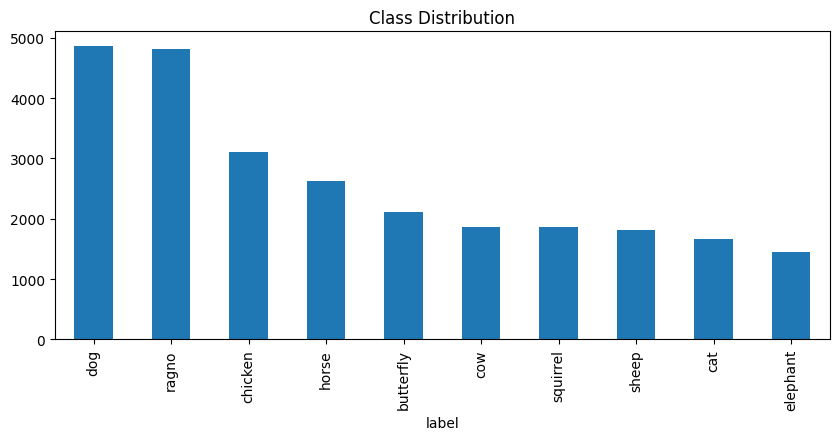

In [13]:
df["label"].value_counts().plot.bar(figsize=(10,4), title="Class Distribution")

As we can see, out of the 26 thousand images we have, most of it are pictures of dogs and spiders. This is great for dog lovers but awful for any arachnophobes. We'll need to balance out the data later but for now, let's look closer at the files themselves and their metadata.

In [14]:
df["file_type"].value_counts()

file_type
.jpeg    24209
.jpg      1919
.png        51
Name: count, dtype: int64

In [15]:
df["color_mode"].value_counts()

color_mode
RGB     26128
RGBA       49
CMYK        1
L           1
Name: count, dtype: int64

In [16]:
df.describe()[["width", "height"]]

,width,height
count,26179.000000,26179.000000
mean,320.038810,252.630162
std,196.935326,148.403298
min,60.000000,57.000000
25%,300.000000,200.000000
50%,300.000000,225.000000
75%,300.000000,300.000000
max,6720.000000,6000.000000


According to the data, the images don't follow a uniform file type, nor resolution. The file type doesn't really matter, when training a CNN, however we will need to pad, scale or cut up the images into a uniform resolution.

The image filter actually helps us, because we can train the CNN on more robust data, however we don' have much of them. We can later create artificial robustness in our data using augmentations.

## 2. Preprocessing

In [17]:
df = df[df['color_mode'] == 'RGB']

In [18]:
print(df['color_mode'].value_counts())

color_mode
RGB    26128
Name: count, dtype: int64



Original class distribution:
label
dog          4863
ragno        4820
chicken      3098
horse        2623
butterfly    2073
cow          1866
squirrel     1862
sheep        1820
cat          1667
elephant     1436
Name: count, dtype: int64

Balanced class distribution:
label
horse        2000
chicken      2000
dog          2000
butterfly    2000
ragno        2000
cow          1866
squirrel     1862
sheep        1820
cat          1667
elephant     1436
Name: count, dtype: int64


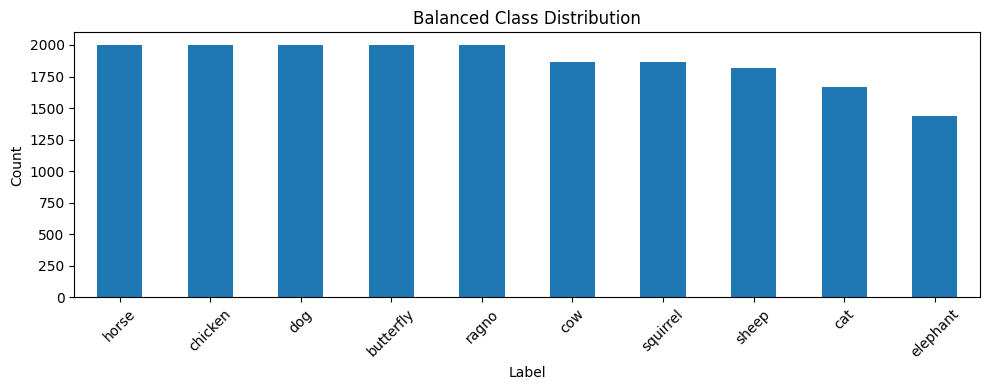

In [19]:
def balance_dataset(df, target_samples_per_class=2000, method='undersample'):
    balanced_dfs = []
    
    for label in df['label'].unique():
        class_df = df[df['label'] == label]
        n_samples = len(class_df)
        
        if method == 'undersample':
            # Undersample to target
            if n_samples > target_samples_per_class:
                class_df = resample(class_df, 
                                  n_samples=target_samples_per_class,
                                  random_state=42,
                                  replace=False)
        elif method == 'oversample':
            # Oversample to target
            if n_samples < target_samples_per_class:
                class_df = resample(class_df,
                                  n_samples=target_samples_per_class,
                                  random_state=42,
                                  replace=True)
        
        balanced_dfs.append(class_df)
    
    return pd.concat(balanced_dfs, ignore_index=True)

print("\nOriginal class distribution:")
print(df['label'].value_counts())

df_balanced = balance_dataset(df, target_samples_per_class=2000, method='undersample')

print("\nBalanced class distribution:")
print(df_balanced['label'].value_counts())

# Visualize balanced distribution
plt.figure(figsize=(10, 4))
df_balanced['label'].value_counts().plot.bar(title="Balanced Class Distribution")
plt.ylabel("Count")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
train_df, temp_df = train_test_split(
    df_balanced, 
    test_size=0.3, 
    stratify=df_balanced['label'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

print(f"\nTrain size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


Train size: 13055
Validation size: 2798
Test size: 2798


In [21]:
def check_loaded_images(generator, n_batches=3):
    print("\n" + "="*60)
    print("="*60)
    
    shapes = []
    dtypes = []
    value_ranges = []
    
    for i in range(n_batches):
        batch_images, batch_labels = next(generator)
        
        for img in batch_images:
            shapes.append(img.shape)
            dtypes.append(img.dtype)
            value_ranges.append((img.min(), img.max()))
    
    shapes = np.array(shapes)
    
    print(f"Checked {len(shapes)} images from generator")
    print(f"\nImage shapes: {np.unique(shapes, axis=0)}")
    print(f"Data types: {set(dtypes)}")
    print(f"Value range: min={min([r[0] for r in value_ranges]):.4f}, "
          f"max={max([r[1] for r in value_ranges]):.4f}")
    print(f"Expected: shape=(224, 224, 3), dtype=float32, range=[0.0, 1.0]")
    
    if all(shape[2] == 3 for shape in shapes):
        print("All images have RGB")
    else:
        print("WARNING: Some images are not RGB!")
    
    return shapes, dtypes, value_ranges


In [22]:
IMG_SIZE = (224, 224)  
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0,1]
    rotation_range=20,           # Randomly rotate images
    width_shift_range=0.2,       # Randomly shift images horizontally
    height_shift_range=0.2,      # Randomly shift images vertically
    horizontal_flip=True,        # Randomly flip images
    zoom_range=0.2,              # Randomly zoom images
    shear_range=0.2,             # Shear transformations
    fill_mode='nearest'          # Fill strategy for new pixels
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nNumber of classes: {len(train_generator.class_indices)}")
print(f"Class indices: {train_generator.class_indices}")
print(f"Number of training batches: {len(train_generator)}")
print(f"Number of validation batches: {len(val_generator)}")
print(f"Number of test batches: {len(test_generator)}")

shapes, dtypes, value_ranges = check_loaded_images(train_generator, n_batches=3)

Found 13055 validated image filenames belonging to 10 classes.
Found 2798 validated image filenames belonging to 10 classes.
Found 2798 validated image filenames belonging to 10 classes.

Number of classes: 10
Class indices: {'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'ragno': 7, 'sheep': 8, 'squirrel': 9}
Number of training batches: 408
Number of validation batches: 88
Number of test batches: 88

Checked 96 images from generator

Image shapes: [[224 224   3]]
Data types: {dtype('float32')}
Value range: min=0.0000, max=1.0000
Expected: shape=(224, 224, 3), dtype=float32, range=[0.0, 1.0]
All images have RGB


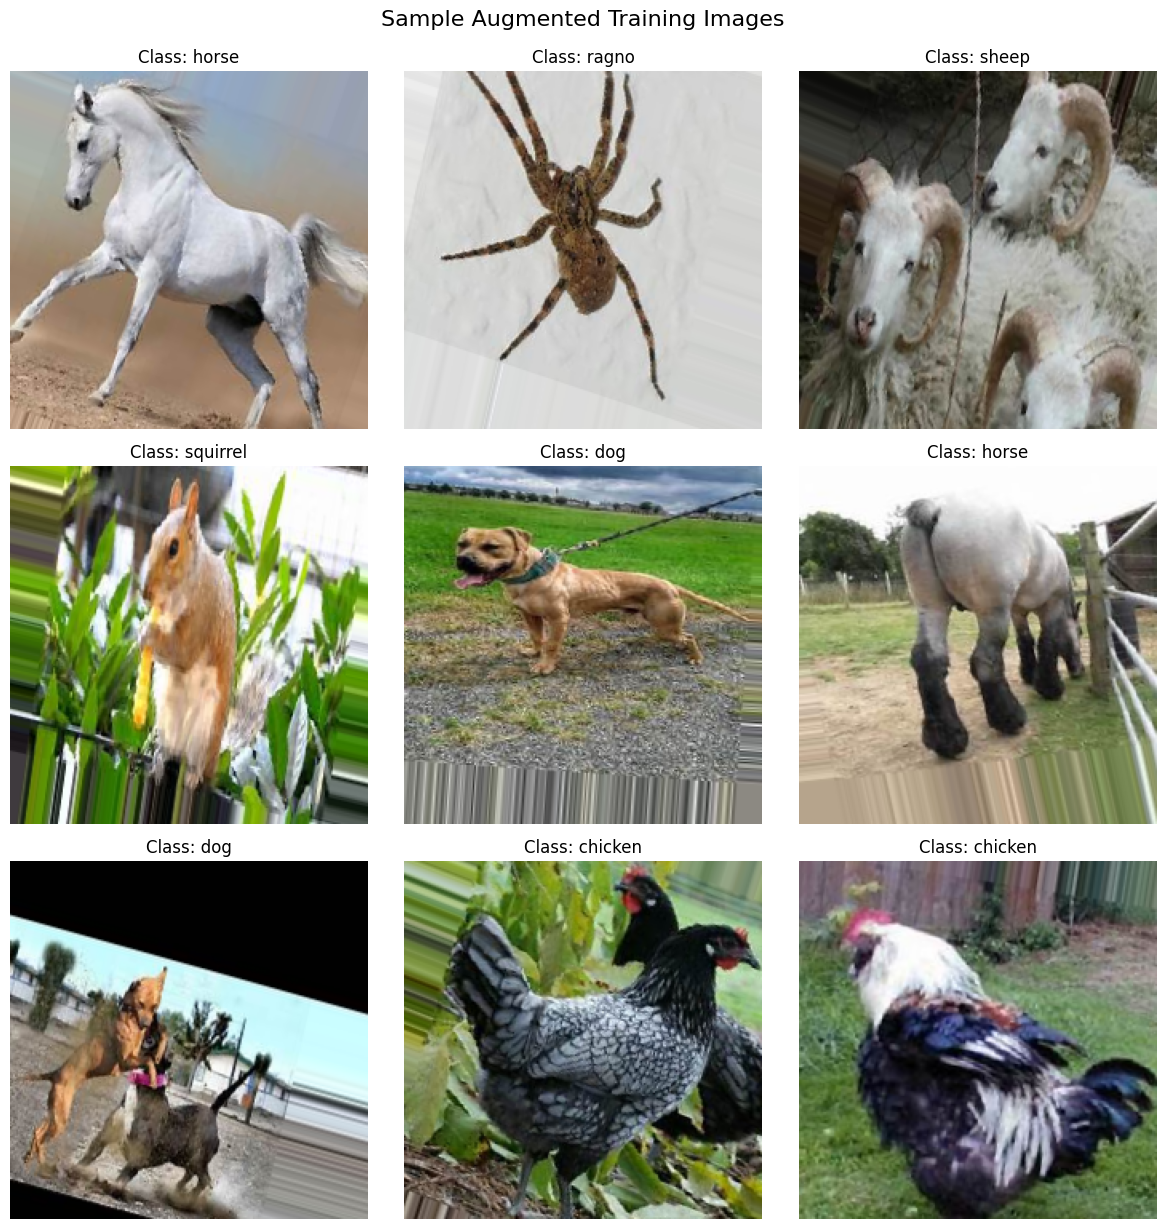

In [23]:
def visualize_augmentations(generator, n_images=9):
    images, labels = next(generator)
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()
    
    for i in range(min(n_images, len(images))):
        axes[i].imshow(images[i])
        axes[i].axis('off')
        # Get class name from label
        class_idx = np.argmax(labels[i])
        class_name = list(generator.class_indices.keys())[class_idx]
        axes[i].set_title(f"Class: {class_name}")
    
    plt.tight_layout()
    plt.suptitle("Sample Augmented Training Images", y=1.02, fontsize=16)
    plt.show()
visualize_augmentations(train_generator)

In [24]:
print(f"Target image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Target image size: (224, 224)
Batch size: 32
Training samples: 13055
Validation samples: 2798
Test samples: 2798


## 3. Model Training

In [25]:
def create_simple_cnn(input_shape=(128, 128, 3), num_classes=10):
    """
    Create a simple CNN architecture for image classification
    
    Architecture:
    - 3 Convolutional blocks (Conv2D + MaxPooling + Dropout)
    - Flatten layer
    - 2 Dense layers with dropout
    - Output layer with softmax
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fourth convolutional block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [26]:
NUM_CLASSES = len(train_generator.class_indices)
IMG_SHAPE = (224, 224, 3)

model = create_simple_cnn(input_shape=IMG_SHAPE, num_classes=NUM_CLASSES)

print("MODEL ARCHITECTURE")
model.summary()


I0000 00:00:1764506376.097709      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764506376.098280      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 26,217,930 (100.01 MB)

 Trainable params: 26,215,434 (100.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [27]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy', 
    metrics=['accuracy', 
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

In [28]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stop, reduce_lr]


In [29]:
print("TRAINING MODEL")

EPOCHS = 20 

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

TRAINING MODEL


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1764506383.786450     132 service.cc:148] XLA service 0x7beba8008fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764506383.787676     132 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764506383.787698     132 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764506384.552915     132 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/408 ━━━━━━━━━━━━━━━━━━━━ 37s 92ms/step - accuracy: 0.0859 - loss: 3.6166 - precision: 0.1356 - recall: 0.0625   

I0000 00:00:1764506395.151348     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


408/408 ━━━━━━━━━━━━━━━━━━━━ 197s 444ms/step - accuracy: 0.1752 - loss: 2.9025 - precision: 0.2185 - recall: 0.0752 - val_accuracy: 0.1590 - val_loss: 2.8715 - val_precision: 0.2454 - val_recall: 0.0425 - learning_rate: 0.0010
Epoch 2/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 170s 418ms/step - accuracy: 0.2869 - loss: 2.1049 - precision: 0.4253 - recall: 0.1062 - val_accuracy: 0.3799 - val_loss: 1.8198 - val_precision: 0.5092 - val_recall: 0.1580 - learning_rate: 0.0010
Epoch 3/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 166s 405ms/step - accuracy: 0.3507 - loss: 1.8279 - precision: 0.5664 - recall: 0.1383 - val_accuracy: 0.4214 - val_loss: 1.5837 - val_precision: 0.6255 - val_recall: 0.2191 - learning_rate: 0.0010
Epoch 4/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 165s 403ms/step - accuracy: 0.4043 - loss: 1.6955 - precision: 0.6152 - recall: 0.1784 - val_accuracy: 0.5247 - val_loss: 1.3687 - val_precision: 0.7544 - val_recall: 0.2766 - learning_rate: 0.0010
Epoch 5/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 163s 400ms/step - a

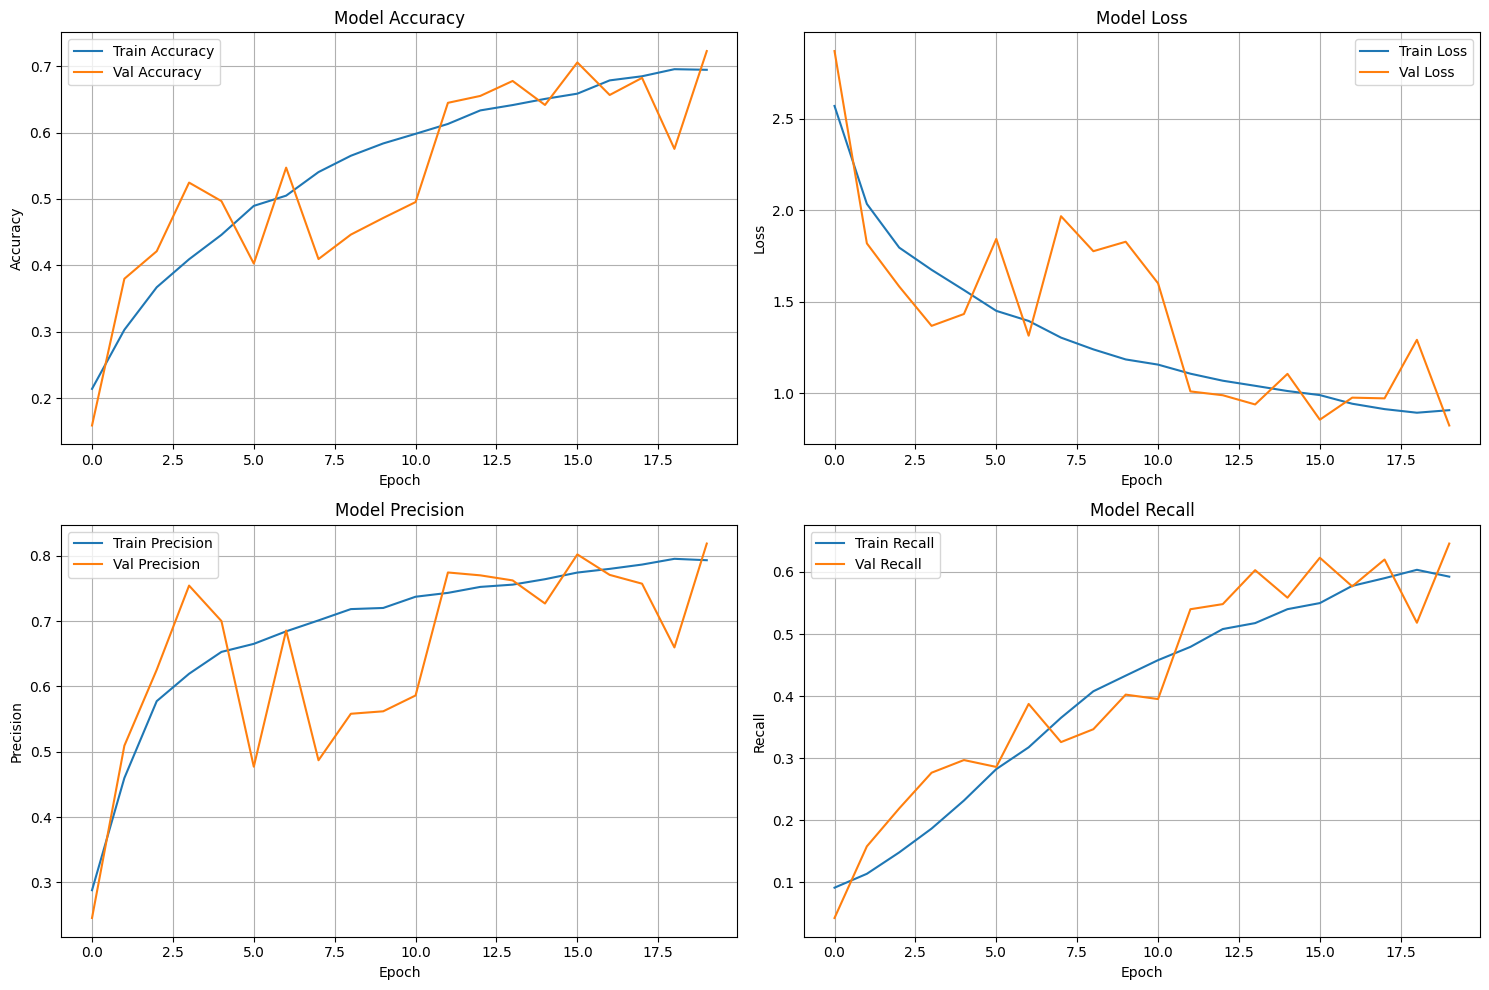

In [36]:
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
plot_training_history(history)


Generating predictions...
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step


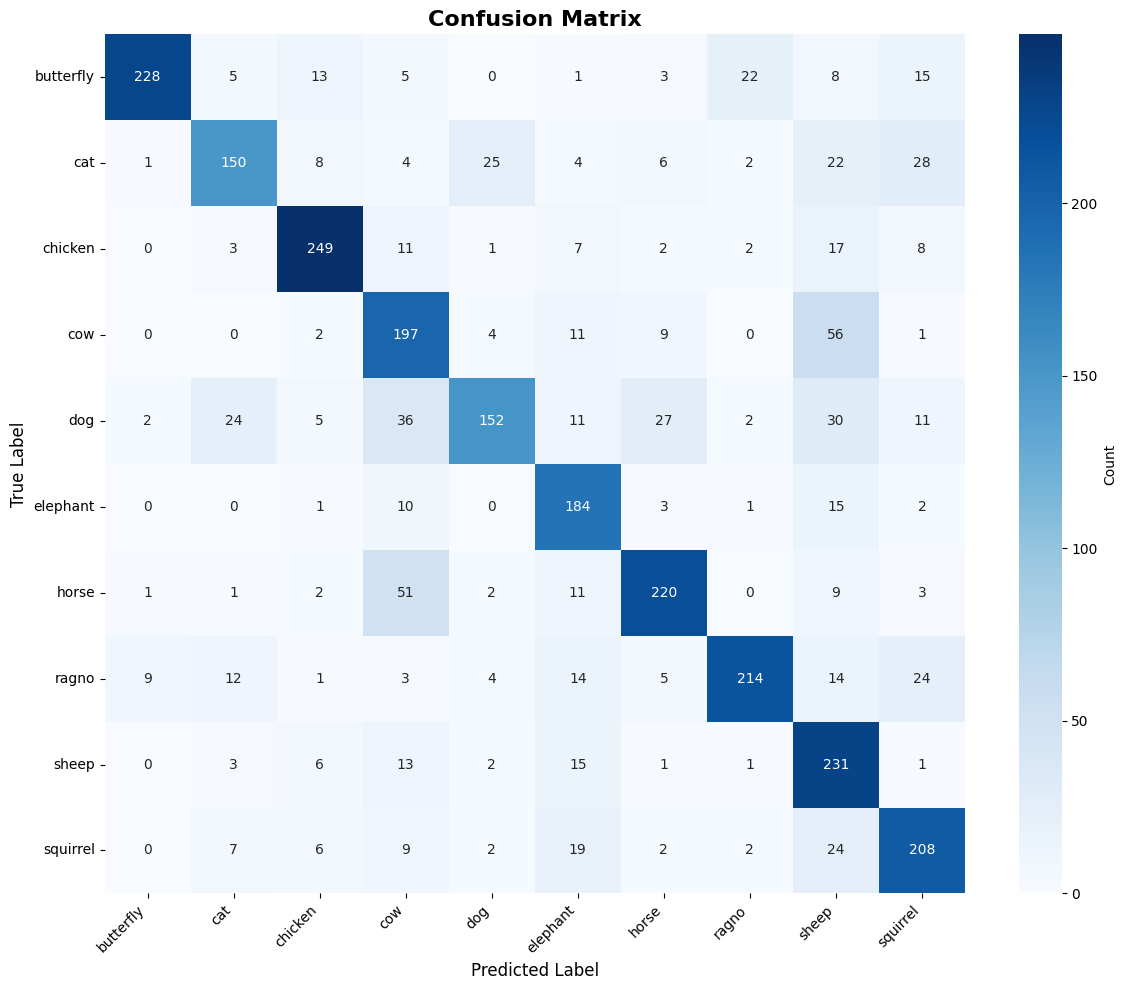

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
print("\nGenerating predictions...")
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Get class names
class_names = list(train_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## BONUS: t-SNE Visualization

In [ ]:
feature_extractor = keras.Model(
    inputs=model.inputs,
    outputs=model.layers[-2].output  #I love python arrays
)

print(f"Feature extractor output shape: {feature_extractor.output.shape}")

In [ ]:
features = []
labels = []

for images, label_batch in val_generator:
    feature_batch = feature_extractor.predict(images, verbose=0)
    features.append(feature_batch)
    labels.append(label_batch)

    #stop if validation done
    if len(features) * val_generator.batch_size >= len(val_generator.filenames):
        break

features = np.vstack(features) #get features (points)
labels = np.vstack(labels) #get labels
label_indices = np.argmax(labels, axis=1)
class_names = list(val_generator.class_indices.keys()) #get animals

In [ ]:
#create a t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
features_2d = tsne.fit_transform(features) #reduces to 2D
colors = plt.cm.tab10(np.linspace(0, 1, 10)) #generated code for 10 random colours

In [ ]:
plt.figure(figsize=(12, 10))

for i, class_name in enumerate(class_names):
    mask = label_indices == i
    plt.scatter(
        features_2d[mask, 0],
        features_2d[mask, 1],
        c=[colors[i]],
        label=class_name,
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.title('t-SNE Visualization of Second-to-Last Layer Features', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()